In [1]:
import pandas as pd
import numpy as np 

In [3]:
import nltk 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
seed = 4262

In [4]:
fake=pd.read_csv("fake.csv")
true=pd.read_csv("true.csv")

In [5]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
fake.shape,true.shape

((23481, 4), (21417, 4))

In [8]:
cols = fake.columns
num_cols = fake._get_numeric_data().columns
a=list(set(cols) - set(num_cols))
print('No of Categorical columns:',len(a),"\n",a)

No of Categorical columns: 4 
 ['text', 'date', 'title', 'subject']


In [9]:
print("No of Continuous columns:",len(fake._get_numeric_data().columns))
print(fake._get_numeric_data().columns)

No of Continuous columns: 0
Index([], dtype='object')


In [10]:
print("No of Continuous columns:",len(true._get_numeric_data().columns))
print(true._get_numeric_data().columns)

No of Continuous columns: 0
Index([], dtype='object')


In [11]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [12]:
#Add new columns in both dataframe
true['impression']=1
fake['impression']=0

In [13]:
data=pd.concat([true,fake],axis=0)
data.sample(3)

,title,text,subject,date,impression
20371,"Hurricane Irma kills 10 in Cuba, Castro calls ...",HAVANA (Reuters) - President Raul Castro calle...,worldnews,"September 11, 2017",1
821,Trump backs New York in bourses' battle for Sa...,"WASHINGTON/KHOBAR, Saudi Arabia (Reuters) - U....",politicsNews,"November 4, 2017",1
17188,BENGHAZI SPOKESLIAR SUSAN RICE TELLS CNN: ‘We ...,"Tell us Susan what s worse, Iran with a nuclea...",Government News,"Jul 17, 2015",0


In [14]:
data['fulltext']=data['title']+' '+data['text']

In [15]:
data.drop(['text','title'],axis=1,inplace=True)

In [16]:
data.sample(4)

,subject,date,impression,fulltext
9103,politicsNews,"June 16, 2016",1,"Labor powerhouse AFL-CIO backs Clinton, vows '..."
8881,politicsNews,"July 5, 2016",1,Republican Trump says 'system is rigged' after...
15943,Government News,"Sep 16, 2017",0,Socialist Utopia of Venezuela Tells People to ...
5927,News,"June 11, 2016",0,Trump’s Relationship With This Woman Could Le...


In [17]:
data.isna().sum()

subject       0
date          0
impression    0
fulltext      0
dtype: int64

In [18]:
data.shape

(44898, 4)

In [19]:
true_text = data[data.impression==1]['fulltext']
# true_text = fake_text.reset_index().drop(['index'], axis=1)

In [20]:
true_text.head()

0    As U.S. budget fight looms, Republicans flip t...
1    U.S. military to accept transgender recruits o...
2    Senior U.S. Republican senator: 'Let Mr. Muell...
3    FBI Russia probe helped by Australian diplomat...
4    Trump wants Postal Service to charge 'much mor...
Name: fulltext, dtype: object

In [21]:
fake_text = data[data.impression==0]['fulltext']
fake_text = fake_text.reset_index().drop(['index'], axis=1)

In [22]:
fake_text.head()

,fulltext
0,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...


In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string

In [24]:
import re
def wordcloud_words(data_full):
    
    # function for removing punctuations
    def remove_punct(data_func):
        string1 = data_func.lower()
        translation_table = dict.fromkeys(map(ord, string.punctuation),' ')
        string2 = string1.translate(translation_table)
        return string2
    
    data_full_clear_punct = []
    for i in range(len(data_full)):
        test_data = remove_punct(data_full[i])
        data_full_clear_punct.append(test_data)
        
    # function to remove stopwords
    def remove_stopwords(data_func):
        pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
        string2 = pattern.sub(' ', data_func)
        return string2
    
    data_full_clear_stopwords = []
    for i in range(len(data_full)):
        test_data = remove_stopwords(data_full[i])
        data_full_clear_stopwords.append(test_data)
        
    # function for tokenizing
    def tokenize_words(data_func):
        words = nltk.word_tokenize(data_func)
        return words
    
    data_full_tokenized_words = []
    for i in range(len(data_full)):
        test_data = tokenize_words(data_full[i])
        data_full_tokenized_words.append(test_data)
        
    # function for lemmatizing
    lemmatizer = WordNetLemmatizer()
    def lemmatize_words(data_func):
        words = lemmatizer.lemmatize(data_func)
        return words
     
    data_full_lemmatized_words = []
    for i in range(len(data_full)):
        test_data = lemmatize_words(data_full[i])
        data_full_lemmatized_words.append(test_data)
        
    return data_full_lemmatized_words

In [25]:
true_words = wordcloud_words(true_text)
fake_words = wordcloud_words(fake_text.fulltext)

In [26]:
def plot_wordcloud(text):
    wordcloud = WordCloud(background_color = 'black',
                         max_words = 3000,
                         width=1600,
                         height=800).generate(text)
    plt.clf()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

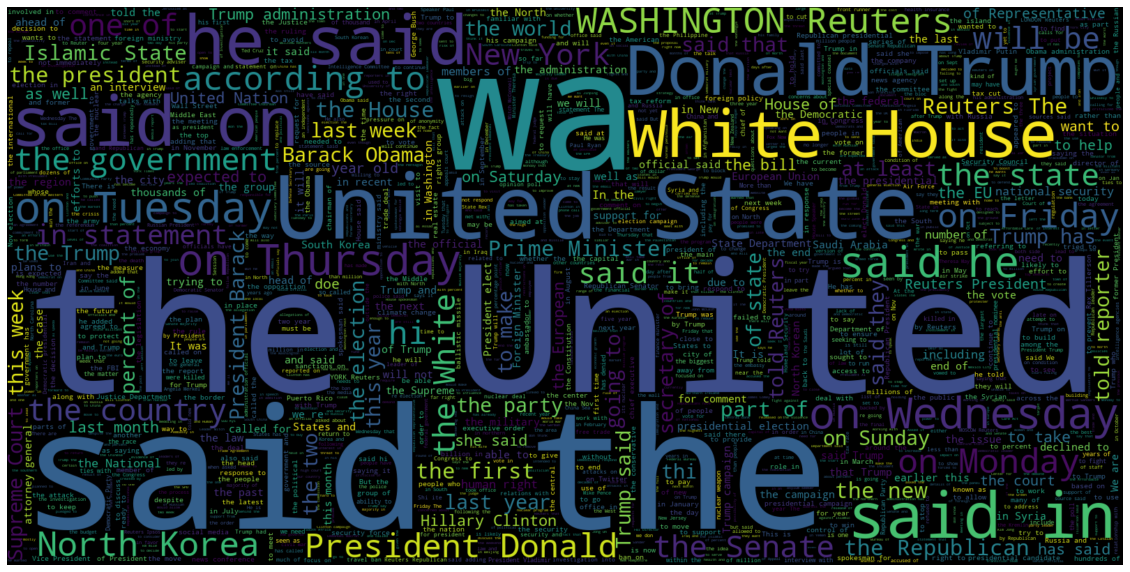

In [27]:
plt.figure(figsize=(20,18))
plot_wordcloud(' '.join(true_words))

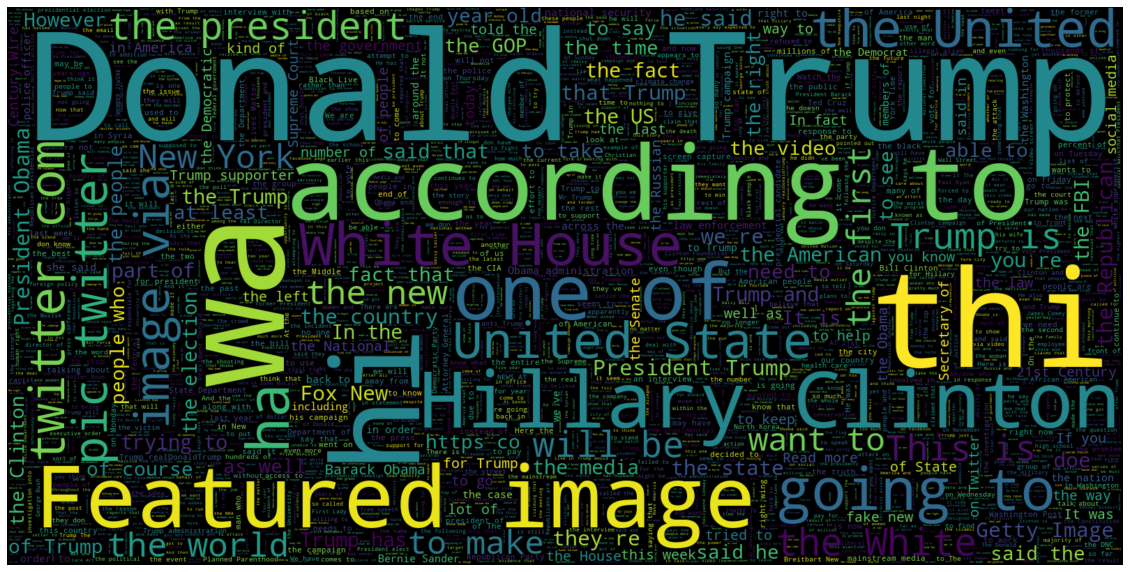

In [28]:
plt.figure(figsize=(20,18))
plot_wordcloud(' '.join(fake_words))

In [29]:
data.columns

Index(['subject', 'date', 'impression', 'fulltext'], dtype='object')

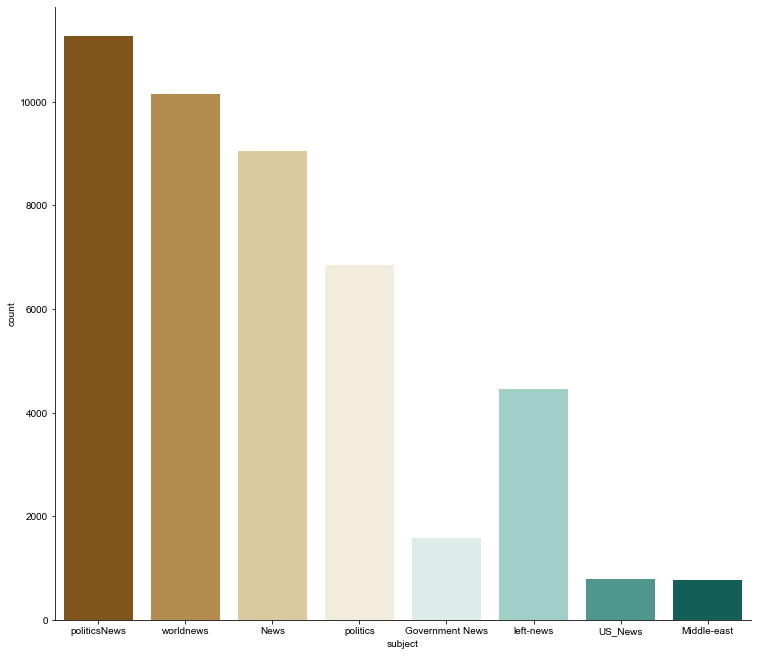

In [30]:
g=sns.catplot(x="subject", kind="count", data=data,palette="BrBG")
g.fig.set_figwidth(12)
g.fig.set_figheight(10)
sns.set_style('darkgrid')
plt.show()

In [31]:
data['fulltext'] = data['fulltext'].apply((lambda y:re.sub("http://\S+"," ", y)))
data['fulltext'] = data['fulltext'].apply((lambda x:re.sub("\@", " ",x.lower())))

In [32]:
data.head()

,subject,date,impression,fulltext
0,politicsNews,"December 31, 2017",1,"as u.s. budget fight looms, republicans flip t..."
1,politicsNews,"December 29, 2017",1,u.s. military to accept transgender recruits o...
2,politicsNews,"December 31, 2017",1,senior u.s. republican senator: 'let mr. muell...
3,politicsNews,"December 30, 2017",1,fbi russia probe helped by australian diplomat...
4,politicsNews,"December 29, 2017",1,trump wants postal service to charge 'much mor...


In [33]:
 def basic_clean(text):
        wnl = nltk.stem.WordNetLemmatizer()
        stopwords = nltk.corpus.stopwords.words('english')
        words = re.sub(r'[^\w\s]', '', text).split()
        return [wnl.lemmatize(word) for word in words if word not in stopwords]
"""
A simple function to clean up the data. All the words that
are not designated as a stop word is then lemmatized after
encoding and basic regex parsing are performed.
"""

'\nA simple function to clean up the data. All the words that\nare not designated as a stop word is then lemmatized after\nencoding and basic regex parsing are performed.\n'

In [34]:
true_word = basic_clean(''.join(str(true['text'].tolist())))

# N-Gram Analysis




In the fields of computational linguistics and probability, an n-gram is a contiguous sequence of n items from a given sample of text or speech. The items can be phonemes, syllables, letters, words or base pairs according to the application. The n-grams typically are collected from a text or speech corpus. When the items are words, n-grams may also be called shingles

## N-gram Analysis - Bigram and Trigram

### N-gram for true news

In [35]:
true_bigrams_series = (pd.Series(nltk.ngrams(true_word, 2)).value_counts())[:20]

### True News - Bigram

Text(0.5, 0, '# of Occurances')

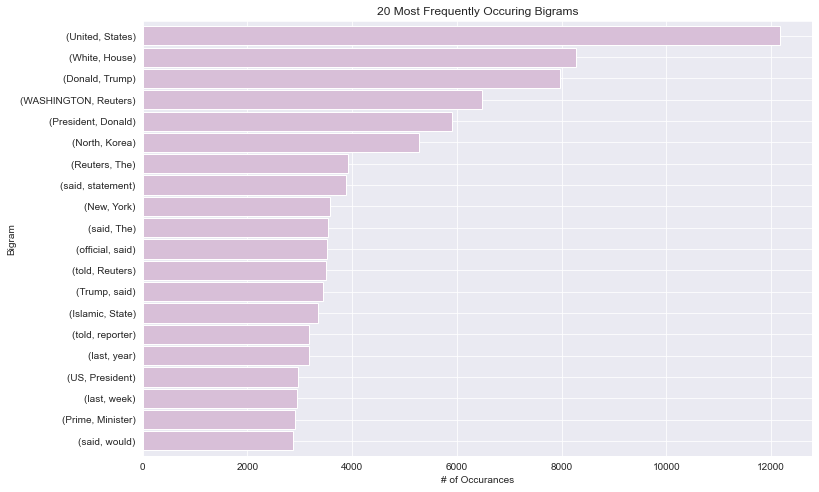

In [36]:
true_bigrams_series.sort_values().plot.barh(color='thistle', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

### True News - Trigram

Text(0.5, 0, '# of Occurances')

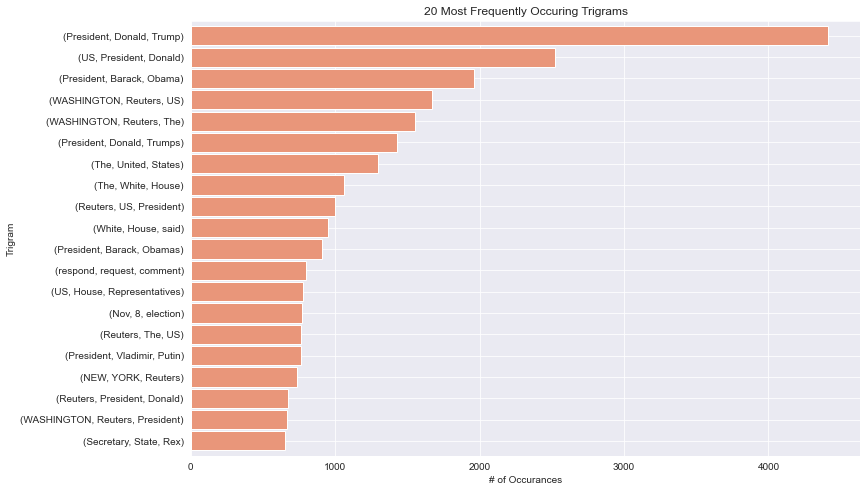

In [37]:
true_trigrams_series = (pd.Series(nltk.ngrams(true_word, 3)).value_counts())[:20]
true_trigrams_series.sort_values().plot.barh(color='darksalmon', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

### N-Gram for False word Analysis

In [38]:
fake_word = basic_clean(''.join(str(fake['text'].tolist())))

In [39]:
fake_bigrams_series = (pd.Series(nltk.ngrams(fake_word, 2)).value_counts())[:20]

### False News Bigram

Text(0.5, 0, '# of Occurances')

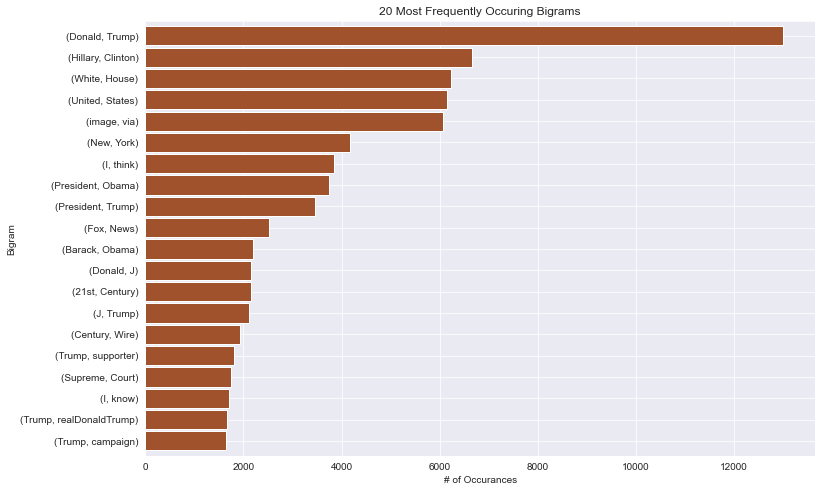

In [40]:
fake_bigrams_series.sort_values().plot.barh(color='sienna', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

### Fakse News Trigram

Text(0.5, 0, '# of Occurances')

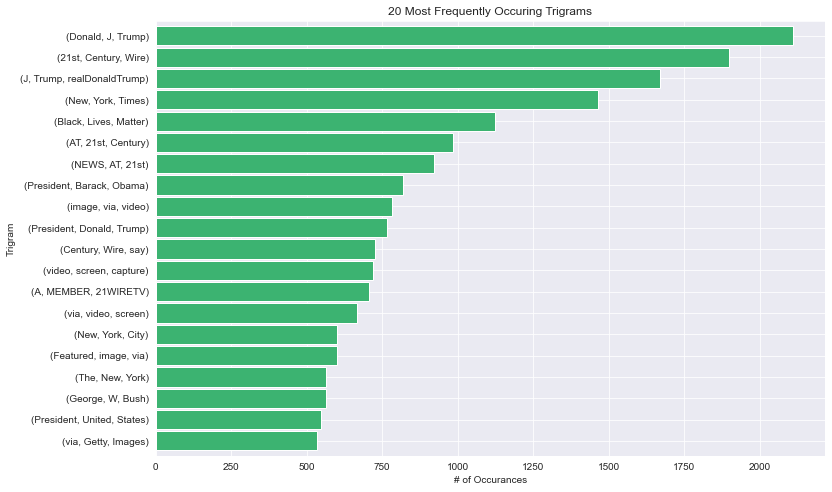

In [42]:
fake_trigrams_series = (pd.Series(nltk.ngrams(fake_word, 3)).value_counts())[:20]
fake_trigrams_series.sort_values().plot.barh(color='mediumseagreen', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

# Full Dataset Analysis

In [43]:
words = basic_clean(''.join(str(data['fulltext'].tolist())))

### Full Data Bigram Analysis

In [44]:
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:20]

Text(0.5, 0, '# of Occurances')

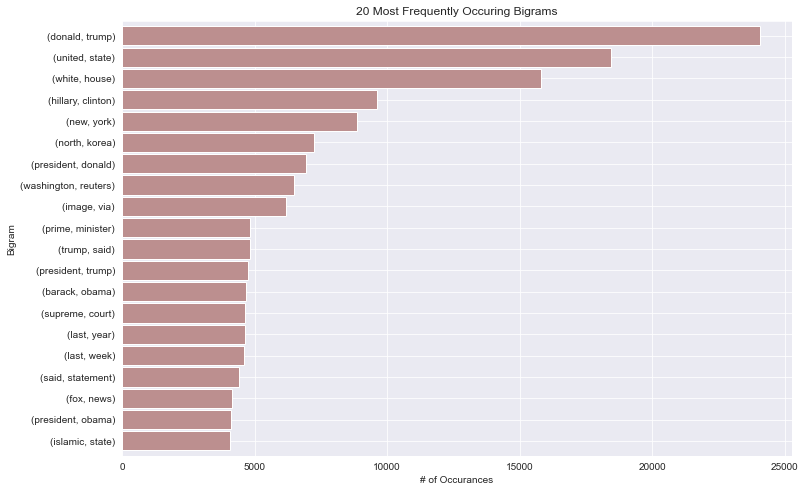

In [45]:
bigrams_series.sort_values().plot.barh(color='rosybrown', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

### Full Data Trigram

In [46]:
trigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:20]

Text(0.5, 0, '# of Occurances')

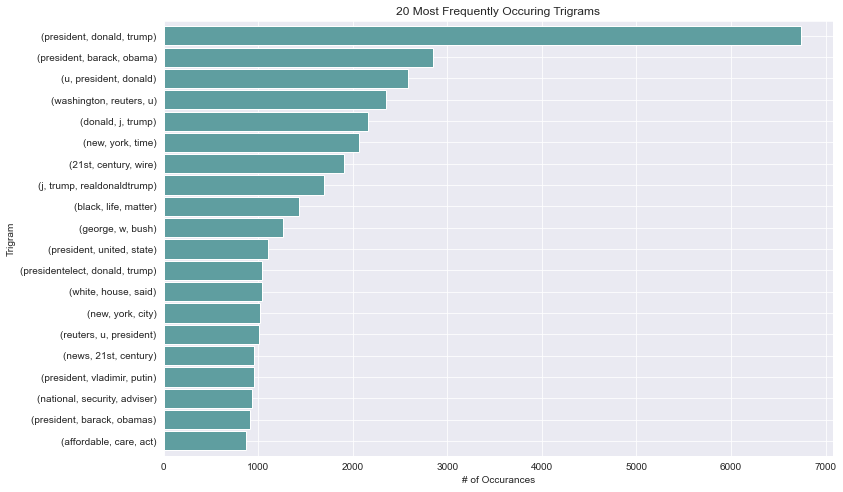

In [47]:
trigrams_series.sort_values().plot.barh(color='cadetblue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

In [48]:
X=data.fulltext
Y=data.impression

# Support Vector Classifier

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer # for bag of words 
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

In [50]:
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=0)

pipe = Pipeline([('vect', CountVectorizer()), # for bag of words
                 ('tfidf', TfidfTransformer()),
                 ('model', LinearSVC())])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("Accuracy of SVC: {}%".format(accuracy_score(y_test, prediction)*100,2))

Accuracy of SVC: 99.57683741648107%


In [51]:
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,plot_confusion_matrix

In [52]:
print(confusion_matrix(y_test, prediction)) #[TP/FN][FP/TN]

[[7038   31]
 [  26 6375]]


In [53]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7069
           1       1.00      1.00      1.00      6401

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470



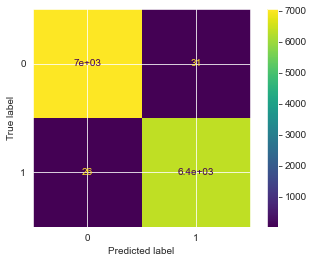

In [54]:
plot_confusion_matrix(model,x_test,y_test)


# Logistic Regression


In [55]:
from sklearn.linear_model import LogisticRegression

In [56]:
fpipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("Accuracy of Logistic Regression: {}%".format(accuracy_score(y_test, prediction)*100,2))

Accuracy of Logistic Regression: 99.57683741648107%


In [57]:
print(confusion_matrix(y_test, prediction)) #[TP/FN][FP/TN]

[[7038   31]
 [  26 6375]]


In [58]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7069
           1       1.00      1.00      1.00      6401

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470



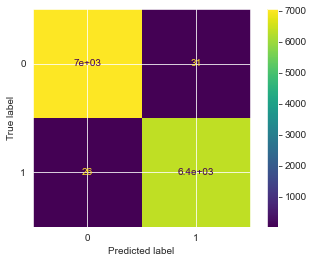

In [59]:
plot_confusion_matrix(model,x_test,y_test)

# KNN

In [60]:
from sklearn.neighbors import KNeighborsClassifier

In [61]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', KNeighborsClassifier(n_neighbors = 10,weights = 'distance',algorithm = 'brute'))])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 90.94%


In [62]:
print(confusion_matrix(y_test, prediction))

[[6347  722]
 [ 499 5902]]


In [63]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      7069
           1       0.89      0.92      0.91      6401

    accuracy                           0.91     13470
   macro avg       0.91      0.91      0.91     13470
weighted avg       0.91      0.91      0.91     13470



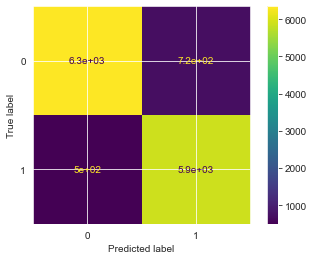

In [64]:
plot_confusion_matrix(model,x_test,y_test)